step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

In [4]:
# import csv
import pandas as pd
#data = pd.read_csv("PS_20174392719_1491204439457_log.csv", nrows=10)
rawdata = pd.read_csv("PS_20174392719_1491204439457_log.csv")
rawdata.head()

# def preprocess(input_file, output_file, keep=1):
#     all_rows = []
#     with open(input_file, 'r') as csvinfile:
#         csv_reader = csv.reader(csvinfile, delimiter=',')
#         for row in csv_reader:
#             all_rows.append(row)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df = pd.DataFrame(data=rawdata)

In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
df.shape

(6362620, 11)

In [8]:
df_w_dummies=pd.get_dummies(df, columns=['type'])

In [9]:
df_w_dummies_removed = df_w_dummies.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_w_dummies_removed.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [10]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_df = scaler.fit_transform(df_w_dummies_removed)
# scaled_df_1 = pd.DataFrame(scaled_df, columns=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], copy=True)
scaled_df_1 = pd.DataFrame(scaled_df)
# # scaled_df = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_df_1.head()
                                             

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000020,0.000357,0.000391,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000002,0.000003,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000002,0.000003,0.000000,0.000059,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.000126,0.000697,0.000603,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
final_df= scaled_df_1
final_df.head()
Y = final_df[6]
Y.head()
X = final_df.drop([6], axis=1)
X.head()

finaldata = pd.concat([Y,X], axis=1)
finaldata

,6,0,1,2,3,4,5,7,8,9,10,11
0,0.0,0.000000,0.000106,0.002855,0.003233,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000000,0.000020,0.000357,0.000391,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
2,1.0,0.000000,0.000002,0.000003,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
3,1.0,0.000000,0.000002,0.000003,0.000000,0.000059,0.000000,0.0,1.0,0.0,0.0,0.0
4,0.0,0.000000,0.000126,0.000697,0.000603,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
5,0.0,0.000000,0.000085,0.000904,0.000929,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
6,0.0,0.000000,0.000077,0.003075,0.003551,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
7,0.0,0.000000,0.000085,0.002955,0.003393,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
8,0.0,0.000000,0.000044,0.000045,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
9,0.0,0.000000,0.000058,0.000700,0.000734,0.000118,0.000113,0.0,0.0,1.0,0.0,0.0


START THE MODEL STEP

In [12]:
import numpy as np

#Splitting data into train and validation
train_data, validation_data, test_data = np.split(finaldata.sample(frac=1, random_state=1729), [int(0.7 * len(finaldata)), int(0.9 * len(finaldata))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [13]:
import boto3

bucket = 'table1-aws-bankfraud'
prefix = 'sagemaker/DEMO-xgboost-churn'

#Putting csv files into s3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [14]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [15]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [16]:
sess = sagemaker.Session()
from sagemaker import get_execution_role
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-08-01 20:49:55 Starting - Starting the training job...
2019-08-01 20:49:56 Starting - Launching requested ML instances......
2019-08-01 20:51:03 Starting - Preparing the instances for training......
2019-08-01 20:52:10 Downloading - Downloading input data...
2019-08-01 20:52:48 Training - Downloading the training image..
Arguments: train
[2019-08-01:20:53:08:INFO] Running standalone xgboost training.
[2019-08-01:20:53:08:INFO] File size need to be processed in the node: 663.51mb. Available memory size in the node: 8455.73mb
[2019-08-01:20:53:08:INFO] Determined delimiter of CSV input is ','
[20:53:08] S3DistributionType set as FullyReplicated
[20:53:10] 4453834x11 matrix with 48992174 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-08-01:20:53:10:INFO] Determined delimiter of CSV input is ','
[20:53:10] S3DistributionType set as FullyReplicated
[20:53:11] 1272524x11 matrix with 13997764 entries loaded from /opt/ml/input/data/validation?form

[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=5
[38]#011train-error:0.000378#011validation-error:0.000375
[20:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=5
[39]#011train-error:0.000374#011validation-error:0.000373
[20:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=5
[40]#011train-error:0.000374#011validation-error:0.000374
[20:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=5
[41]#011train-error:0.000373#011validation-error:0.000374
[20:55:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=5
[42]#011train-error:0.000373#011validation-error:0.000371
[20:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=5
[43]#011train-error:0.000371#011valid

[20:56:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[84]#011train-error:0.000321#011validation-error:0.000334
[20:56:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=5
[85]#011train-error:0.000321#011validation-error:0.000333
[20:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[86]#011train-error:0.000318#011validation-error:0.000332
[20:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[87]#011train-error:0.000317#011validation-error:0.000332
[20:57:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[88]#011train-error:0.000317#011validation-error:0.000328
[20:57:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[89]#011train-error:0.000316#011validat

In [20]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------------------------------------------------------------------------------!

In [21]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [47]:
dtest = test_data.head(5000).as_matrix()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [26]:
xgb_predictor.endpoint

'xgboost-2019-08-01-20-49-55-611'

In [48]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

#dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

In [49]:
pd.crosstab(index=test_data.iloc[:5000, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0.0,4989,0
1.0,2,9


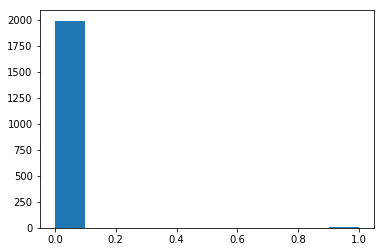

In [46]:
plt.hist(predictions)
plt.show()

In [50]:
pd.crosstab(index=test_data.iloc[:5000, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
6,,
0.0,4988,1
1.0,1,10


In [40]:
predictions

array([3.80302617e-06, 1.50409426e-06, 2.34014060e-05, 1.25811357e-05,
       9.39900929e-06, 1.27597184e-06, 8.13799306e-06, 1.24699898e-06,
       5.93601442e-07, 8.12817962e-05, 1.31880768e-06, 1.29330340e-06,
       1.24645328e-06, 8.26666364e-04, 6.94944674e-06, 4.58318527e-06,
       1.35545940e-06, 5.18330053e-05, 1.42772910e-06, 1.06223224e-05,
       1.68781639e-06, 1.12467728e-06, 2.29599800e-06, 8.42465113e-07,
       2.15804516e-06, 1.82549877e-06, 2.18550190e-06, 3.06156312e-06,
       1.10759777e-06, 8.45140733e-07, 6.28229145e-07, 1.22632855e-06,
       2.05336755e-06, 3.73315584e-06, 7.29677413e-05, 1.08723304e-06,
       3.38296991e-06, 2.56535236e-06, 1.00324660e-05, 2.13217791e-05,
       2.56828253e-06, 2.02901151e-06, 1.22531965e-05, 1.35533014e-06,
       9.34512645e-05, 1.70113196e-06, 1.42539318e-06, 1.71259544e-05,
       1.60576087e-06, 5.02577041e-06, 1.43898171e-06, 8.52227186e-06,
       2.21784057e-06, 6.78733045e-07, 1.76278598e-04, 1.54130112e-06,
      